# Graph Statistics

In this notebook, I will show how to obtain basic graph statistics (number of nodes, density, etc.) from the graphs stored in our filespec.

## Load the Graphs

In [34]:
from c_elegans.witvilet2020.load_wit import load_wit
from c_elegans.worm_wiring.load_worm import load_worm
import networkx as nx
from networkx.algorithms.components import number_strongly_connected_components as ncc_strong
from networkx.algorithms.components import number_weakly_connected_components as ncc_weak
import matplotlib.pyplot as plt
import numpy as np

worm_graphs = load_worm()
wit_graphs = load_wit()
worm_connectomes = worm_graphs[-6:]
worm_contactomes = worm_graphs[:2]
worm_cellclass_omes = worm_graphs[2:8]
worm_synadj = worm_graphs[8:-6]

## Obtain Graph Statistics and Metadata

In [35]:
lcc_size = [] #Instead of number of nodes -- number of nodes in largest weakly connected component
density = []
num_strong = []
num_weak = []
synapse_type = []
sex = []
in_degree = []
out_degree = []
graph_origin = []

for g in worm_connectomes:
    graph_origin.append("worm")
    lcc_size.append(len(max(nx.weakly_connected_components(g))))
    density.append(nx.density(g))
    num_strong.append(ncc_strong(g))
    num_weak.append(ncc_weak(g))
    synapse_type.append(g.graph['Synapse Type'])
    sex.append(g.graph['Sex'])
    in_degree.append([d for _, d in g.in_degree()])
    out_degree.append([d for _, d in g.out_degree()])
    
for graph in wit_graphs:
    chemical_edges = []
    electrical_edges = []
    for *edge, attr in graph.edges(data=True, keys=True):
        if attr['synapse_type'] == "chemical":
            chemical_edges.append((*edge,))
        elif attr['synapse_type'] == "electrical":
            electrical_edges.append((*edge,))
    g_chemical = graph.edge_subgraph(chemical_edges)
    g_electrical = graph.edge_subgraph(electrical_edges)
    for g, syn_type in [(g_chemical, "Chemical"), (g_electrical, "Total Gap Junction")]:
        graph_origin.append("wit")
        lcc_size.append(len(max(nx.weakly_connected_components(g))))
        density.append(nx.density(g))
        num_strong.append(ncc_strong(g))
        num_weak.append(ncc_weak(g))
        synapse_type.append(syn_type)
        sex.append(g.graph['Sex'])
        in_degree.append([d for _, d in g.in_degree()])
        out_degree.append([d for _, d in g.out_degree()])

sex = np.array(sex)
lcc_size = np.array(lcc_size)
density = np.array(density)
num_strong = np.array(num_strong)
num_weak = np.array(num_weak)
graph_origin = np.array(graph_origin)
in_degree = [np.array(ins) for ins in in_degree]
out_degree = [np.array(outs) for outs in out_degree]
synapse_type = np.array(synapse_type)
worm_types = np.array(worm_types)

## Visualize 

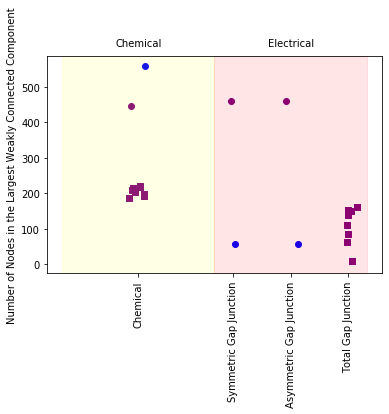

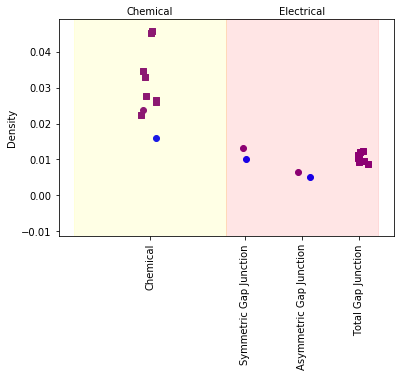

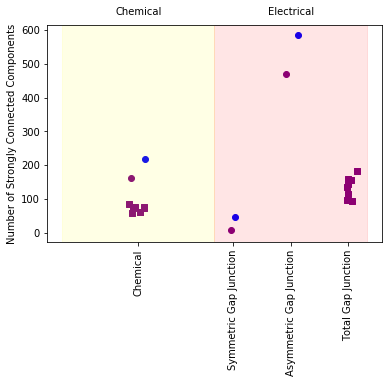

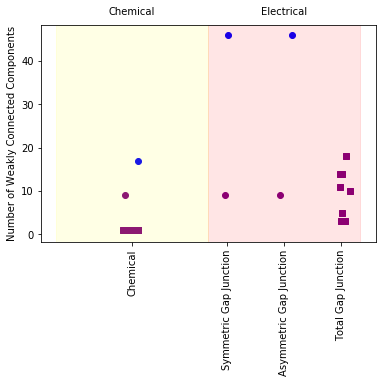

In [36]:
syntypes = ["Chemical", "Symmetric Gap Junction", "Asymmetric Gap Junction", "Total Gap Junction"]
syntype_pos = [0, 1.25, 2., 2.75]
syntype2pos = {syntype:i for i, syntype in zip(syntype_pos, syntypes)}
syn_pos = np.array([syntype2pos[syntype] for syntype in synapse_type])
syn_pos += 0.25*(np.random.rand(syn_pos.shape[0]) - 0.5) #adding jitter
sexes = ["Male", "Hermaphrodite"]
sex2color = {"Male":'b', "Hermaphrodite":'purple'}
sex_colors = [sex2color[isex] for isex in sex]

def vis_stat(stat, stat_name):
    fig_max = np.max(stat)
    fig = plt.figure()
    ax = plt.gca()
    plt.hold=True
    for isex in sexes:
        plt.scatter(syn_pos[np.logical_and(sex==isex, graph_origin=="worm")],
                    stat[np.logical_and(sex==isex, graph_origin=="worm")],
                    c=sex2color[isex],
                    label=isex+", worm wiring",
                    marker='o')
        plt.scatter(syn_pos[np.logical_and(sex==isex, graph_origin=="wit")],
                    stat[np.logical_and(sex==isex, graph_origin=="wit")],
                    c=sex2color[isex],
                    label=isex+", witvilet",
                    marker='s')
    plt.text(syntype_pos[0], 1.1*fig_max, "Chemical", ha="center")
    plt.text(syntype_pos[2], 1.1*fig_max, "Electrical", ha="center")
    plt.hold=False
    plt.ylabel(stat_name)
    ax.xaxis.set_ticks(syntype_pos)
    ax.xaxis.set_ticklabels(syntypes, rotation=90)
    fill_width = 2
    ax.axvspan(syntype_pos[0]-fill_width/2, syntype_pos[0]+fill_width/2, color="yellow", alpha=0.1)
    ax.axvspan(syntype_pos[2]-fill_width/2, syntype_pos[2]+fill_width/2, color="red", alpha=0.1)
    #plt.legend(loc='best', ncol=2)
    return fig
    
fig = vis_stat(lcc_size, "Number of Nodes in the Largest Weakly Connected Component")
fig.savefig("num_nodes.png", bbox_inches="tight")
fig = vis_stat(density, "Density")
fig.savefig("density.png", bbox_inches="tight")
fig = vis_stat(num_strong, "Number of Strongly Connected Components")
fig.savefig("num_strong.png", bbox_inches="tight")
fig = vis_stat(num_weak, "Number of Weakly Connected Components")
fig.savefig("num_weak.png", bbox_inches="tight")

Witvilet-specific graphs

In [46]:
ages = []
microscopy_method = []
for g in wit_graphs:
    ages.append(g.graph['age'])
    microscopy_method.append(g.graph['microscopy_method'])
ages = np.array(ages)
microscopy_method = np.array(microscopy_method)

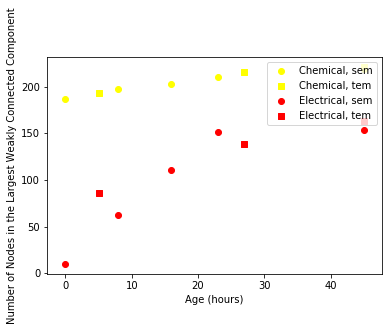

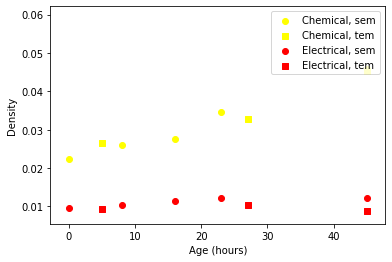

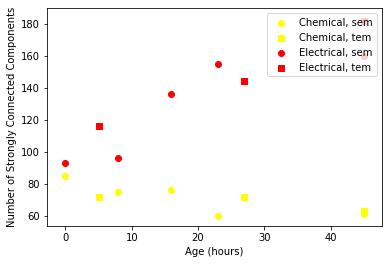

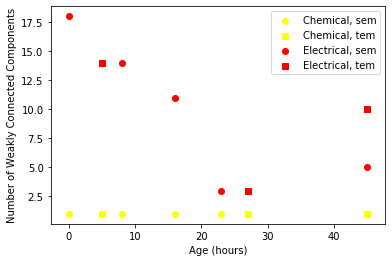

In [49]:
syntypes = ["Chemical", "Symmetric Gap Junction", "Asymmetric Gap Junction", "Total Gap Junction"]
microscopies = ["sem", "tem"]
syntype2color = {"Chemical":"yellow", "Total Gap Junction":"red"}
def vis_stat(stat, stat_name):
    fig_max = np.max(stat)
    fig = plt.figure()
    ax = plt.gca()
    plt.hold=True
    for syntype, synlabel in zip(["Chemical", "Total Gap Junction"], ["Chemical", "Electrical"]):
        for microscopy, marker in zip(microscopies, ["o", "s"]): 
            plt.scatter(ages[microscopy_method==microscopy],
                        stat[np.logical_and(synapse_type==syntype, graph_origin=="wit")][microscopy_method==microscopy],
                        c=syntype2color[syntype],
                        label=synlabel+", "+microscopy,
                        marker=marker)
    plt.hold=False
    plt.xlabel("Age (hours)")
    plt.ylabel(stat_name)
    plt.legend(loc='upper right')
    return fig
    
fig = vis_stat(lcc_size, "Number of Nodes in the Largest Weakly Connected Component")
fig.savefig("num_nodes_age.png", bbox_inches="tight")
fig = vis_stat(density, "Density")
fig.savefig("density_age.png", bbox_inches="tight")
fig = vis_stat(num_strong, "Number of Strongly Connected Components")
fig.savefig("num_strong_age.png", bbox_inches="tight")
fig = vis_stat(num_weak, "Number of Weakly Connected Components")
fig.savefig("num_weak_age.png", bbox_inches="tight")

### Other worm_wiring graphs

Contactome

In [50]:
lcc_size = [] #Instead of number of nodes -- number of nodes in largest weakly connected component
density = []
num_strong = []
num_weak = []
in_degree = []
out_degree = []
graph_title = []

for g in worm_contactomes:
    graph_title.append(g.graph['Title'])
    lcc_size.append(len(max(nx.weakly_connected_components(g))))
    density.append(nx.density(g))
    num_strong.append(ncc_strong(g))
    num_weak.append(ncc_weak(g))
    in_degree.append([d for _, d in g.in_degree()])
    out_degree.append([d for _, d in g.out_degree()])
    
lcc_size = np.array(lcc_size)
density = np.array(density)
num_strong = np.array(num_strong)
num_weak = np.array(num_weak)
graph_origin = np.array(graph_origin)
in_degree = [np.array(ins) for ins in in_degree]
out_degree = [np.array(outs) for outs in out_degree]

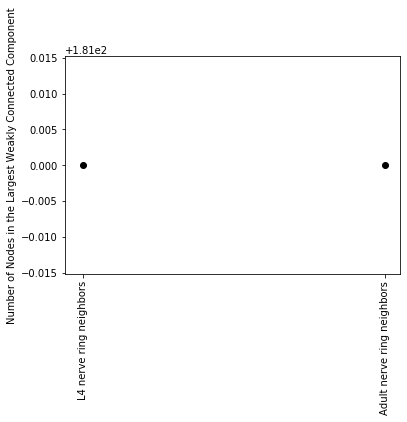

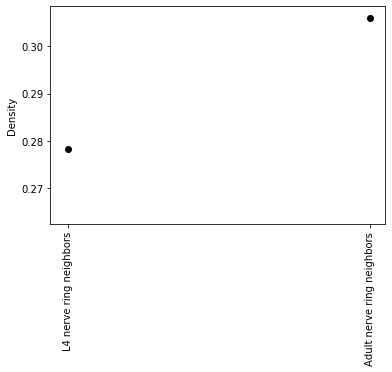

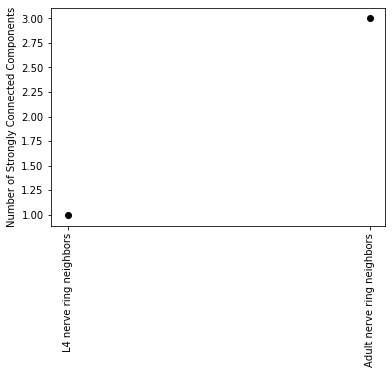

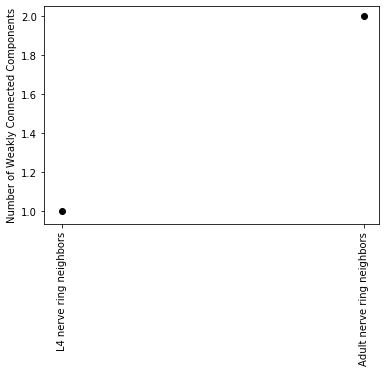

In [56]:
def vis_stat(stat, stat_name):
    stat_pos = list(range(len(stat)))
    fig = plt.figure()
    ax = plt.gca()
    plt.hold=True
    for i, stat_i in enumerate(stat):
        plt.scatter(i, stat_i, label=graph_title[i], c="k")
    plt.hold=False
    plt.ylabel(stat_name)
    ax.xaxis.set_ticks(stat_pos)
    ax.xaxis.set_ticklabels(graph_title, rotation=90)
    return fig
    
fig = vis_stat(lcc_size, "Number of Nodes in the Largest Weakly Connected Component")
fig.savefig("num_nodes_contact.png", bbox_inches="tight")
fig = vis_stat(density, "Density")
fig.savefig("density_contact.png", bbox_inches="tight")
fig = vis_stat(num_strong, "Number of Strongly Connected Components")
fig.savefig("num_strong_contact.png", bbox_inches="tight")
fig = vis_stat(num_weak, "Number of Weakly Connected Components")
fig.savefig("num_weak_contact.png", bbox_inches="tight")

Cellclass-omes

In [59]:
lcc_size = [] #Instead of number of nodes -- number of nodes in largest weakly connected component
density = []
num_strong = []
num_weak = []
synapse_type = []
sex = []
in_degree = []
out_degree = []
graph_origin = []

for g in worm_cellclass_omes:
    graph_origin.append("worm")
    lcc_size.append(len(max(nx.weakly_connected_components(g))))
    density.append(nx.density(g))
    num_strong.append(ncc_strong(g))
    num_weak.append(ncc_weak(g))
    synapse_type.append(g.graph['Synapse Type'])
    sex.append(g.graph['Sex'])
    in_degree.append([d for _, d in g.in_degree()])
    out_degree.append([d for _, d in g.out_degree()])
    
sex = np.array(sex)
lcc_size = np.array(lcc_size)
density = np.array(density)
num_strong = np.array(num_strong)
num_weak = np.array(num_weak)
graph_origin = np.array(graph_origin)
in_degree = [np.array(ins) for ins in in_degree]
out_degree = [np.array(outs) for outs in out_degree]
synapse_type = np.array(synapse_type)
worm_types = np.array(worm_types)

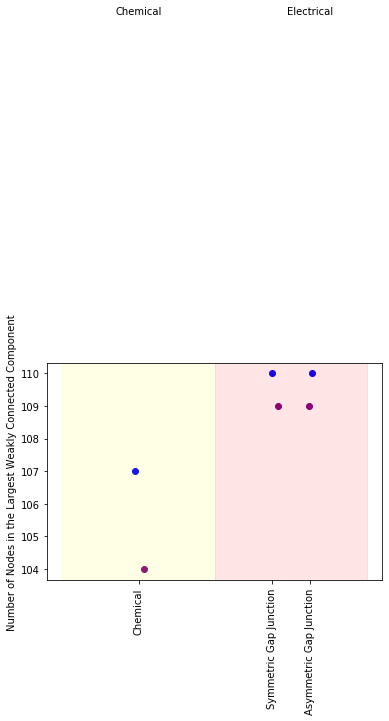

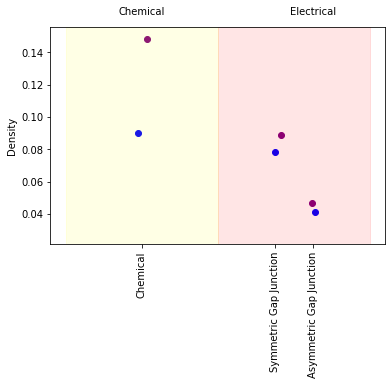

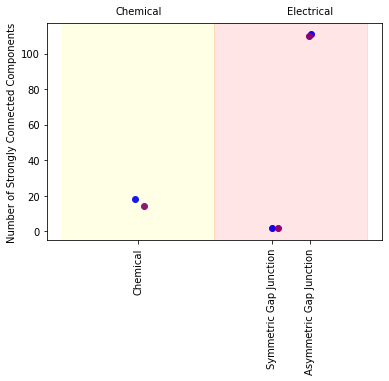

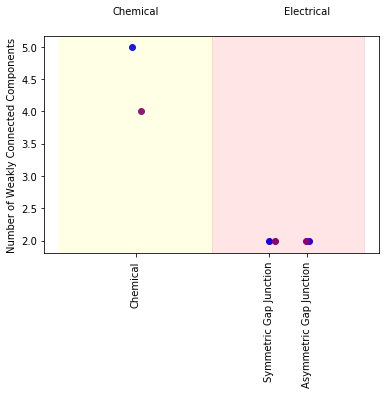

In [63]:
syntypes = ["Chemical", "Symmetric Gap Junction", "Asymmetric Gap Junction"]
syntype_pos = [0, 1.75, 2.25]
syntype2pos = {syntype:i for i, syntype in zip(syntype_pos, syntypes)}
syn_pos = np.array([syntype2pos[syntype] for syntype in synapse_type])
syn_pos += 0.25*(np.random.rand(syn_pos.shape[0]) - 0.5) #adding jitter
sexes = ["Male", "Hermaphrodite"]
sex2color = {"Male":'b', "Hermaphrodite":'purple'}
sex_colors = [sex2color[isex] for isex in sex]

def vis_stat(stat, stat_name):
    fig_max = np.max(stat)
    fig = plt.figure()
    ax = plt.gca()
    plt.hold=True
    for isex in sexes:
        plt.scatter(syn_pos[np.logical_and(sex==isex, graph_origin=="worm")],
                    stat[np.logical_and(sex==isex, graph_origin=="worm")],
                    c=sex2color[isex],
                    label=isex+", worm wiring")
    plt.text(syntype_pos[0], 1.1*fig_max, "Chemical", ha="center")
    plt.text(syntype_pos[2], 1.1*fig_max, "Electrical", ha="center")
    plt.hold=False
    plt.ylabel(stat_name)
    ax.xaxis.set_ticks(syntype_pos)
    ax.xaxis.set_ticklabels(syntypes, rotation=90)
    fill_width = 2
    ax.axvspan(syntype_pos[0]-fill_width/2, syntype_pos[0]+fill_width/2, color="yellow", alpha=0.1)
    ax.axvspan((syntype_pos[1]+syntype_pos[2]-fill_width)/2, (syntype_pos[1]+syntype_pos[2]+fill_width)/2, color="red", alpha=0.1)
    #plt.legend(loc='best', ncol=2)
    return fig
    
fig = vis_stat(lcc_size, "Number of Nodes in the Largest Weakly Connected Component")
fig.savefig("num_nodes_cellclass.png", bbox_inches="tight")
fig = vis_stat(density, "Density")
fig.savefig("density_cellclass.png", bbox_inches="tight")
fig = vis_stat(num_strong, "Number of Strongly Connected Components")
fig.savefig("num_strong_cellclass.png", bbox_inches="tight")
fig = vis_stat(num_weak, "Number of Weakly Connected Components")
fig.savefig("num_weak_cellclass.png", bbox_inches="tight")